In [4]:
import pandas as pd
import numpy as np
import requests
import time

In [3]:
api_key = 'F5OX20J25TH3JKR1'

def fetch_exchange_rate(from_currency, to_currency):
    url = f'https://www.alphavantage.co/query?function=CURRENCY_EXCHANGE_RATE&from_currency={from_currency}&to_currency={to_currency}&apikey={api_key}'
    response = requests.get(url)
    data = response.json()
    if "Realtime Currency Exchange Rate" in data:
        return float(data["Realtime Currency Exchange Rate"]["5. Exchange Rate"])
    else:
        raise ValueError("Error fetching exchange rate")

In [5]:
currencies = ['USD', 'EUR', 'GBP', 'JPY']
exchange_rates = {}

for i in range(len(currencies)):
    for j in range(len(currencies)):
        if i != j:
            from_currency = currencies[i]
            to_currency = currencies[j]
            exchange_rate = fetch_exchange_rate(from_currency, to_currency)
            exchange_rates[(from_currency, to_currency)] = exchange_rate
            time.sleep(12)

# Convert to DataFrame for easy manipulation
df = pd.DataFrame(exchange_rates.values(), index=exchange_rates.keys(), columns=["Exchange Rate"])
print(df)


         Exchange Rate
USD EUR         0.9151
    GBP         0.7832
    JPY       148.1030
EUR USD         1.0929
    GBP         0.8557
    JPY       161.8570
GBP USD         1.2770
    EUR         1.1686
    JPY       189.1750
JPY USD         0.0068
    EUR         0.0062
    GBP         0.0053


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Data in dictionary format
data = {
    ('USD', 'EUR'): 0.9151,
    ('USD', 'GBP'): 0.7832,
    ('USD', 'JPY'): 148.1030,
    ('EUR', 'USD'): 1.0929,
    ('EUR', 'GBP'): 0.8557,
    ('EUR', 'JPY'): 161.8570,
    ('GBP', 'USD'): 1.2770,
    ('GBP', 'EUR'): 1.1686,
    ('GBP', 'JPY'): 189.1750,
    ('JPY', 'USD'): 0.0068,
    ('JPY', 'EUR'): 0.0062,
    ('JPY', 'GBP'): 0.0053,
}

# Convert the dictionary to a DataFrame
df = pd.Series(data).unstack()

print(df)


        EUR     GBP      JPY     USD
EUR     NaN  0.8557  161.857  1.0929
GBP  1.1686     NaN  189.175  1.2770
JPY  0.0062  0.0053      NaN  0.0068
USD  0.9151  0.7832  148.103     NaN


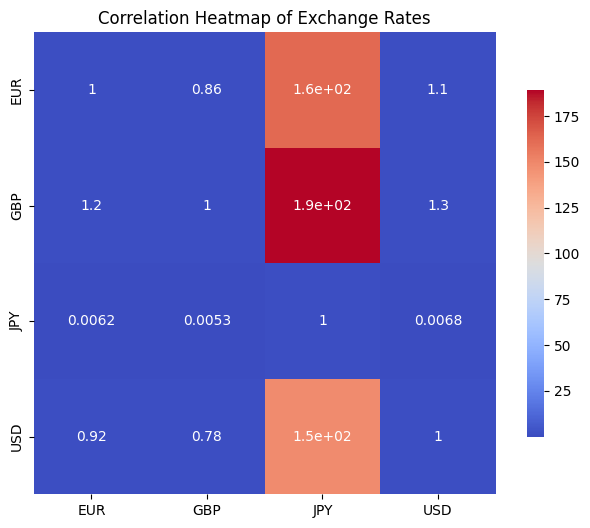

In [36]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the correct aspect ratio
sns.heatmap(df, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink":.75})

plt.title('Correlation Heatmap of Exchange Rates')
plt.show()

In [33]:
df = df.fillna(1)

In [25]:
log_rates = -np.log(df)
log_rates

,EUR,GBP,JPY,USD
EUR,-0.000000,0.155835,-5.086713,-0.088835
GBP,-0.155806,-0.000000,-5.242673,-0.244514
JPY,5.083206,5.240048,-0.000000,4.990833
USD,0.088722,0.244367,-4.997908,-0.000000


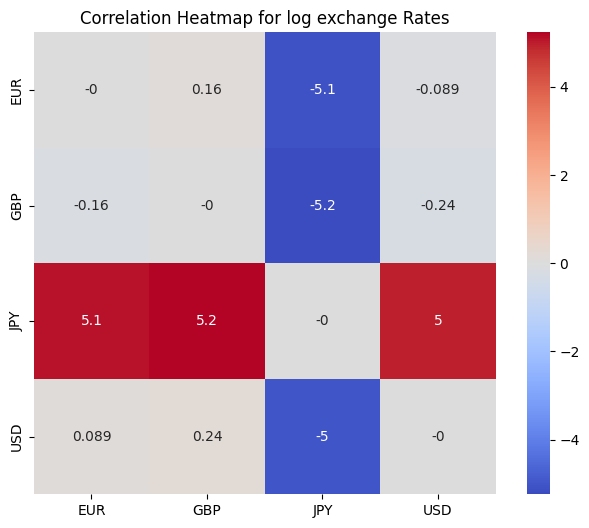

In [27]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the correct aspect ratio
sns.heatmap(log_rates, annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Heatmap for log exchange Rates')
plt.show()

In [52]:
def bellman_ford(log_rates, start_currency):
    currencies = log_rates.index.tolist()
    num_currencies = len(currencies)
    distances = {currency: float('inf') for currency in currencies}
    predecessors = {currency: None for currency in currencies}
    
    distances[start_currency] = 0
    
    for _ in range(num_currencies - 1):
        for u in currencies:
            for v in currencies:
                if distances[u] + log_rates.at[u, v] < distances[v]:
                    distances[v] = distances[u] + log_rates.at[u, v]
                    predecessors[v] = u
    
    # Check for negative-weight cycles (arbitrage opportunity)
    for u in currencies:
        for v in currencies:
            if distances[u] + log_rates.at[u, v] < distances[v]:
                
                arbitrage_path = [v]
                next_currency = u
                while next_currency not in arbitrage_path:
                    arbitrage_path.append(next_currency)
                    next_currency = predecessors[next_currency]
                arbitrage_path.append(next_currency)
                arbitrage_path.reverse()
                return arbitrage_path
    return None


In [59]:
start_currency = 'GBP'  # USD
arbitrage_path = bellman_ford(log_rates, start_currency)

if arbitrage_path:
    print("Arbitrage opportunity found: ")
    for currency in arbitrage_path:
        print(currency, end=" -> ")
else:
    print("No arbitrage opportunity found.")


Arbitrage opportunity found: 
JPY -> USD -> EUR -> JPY -> 

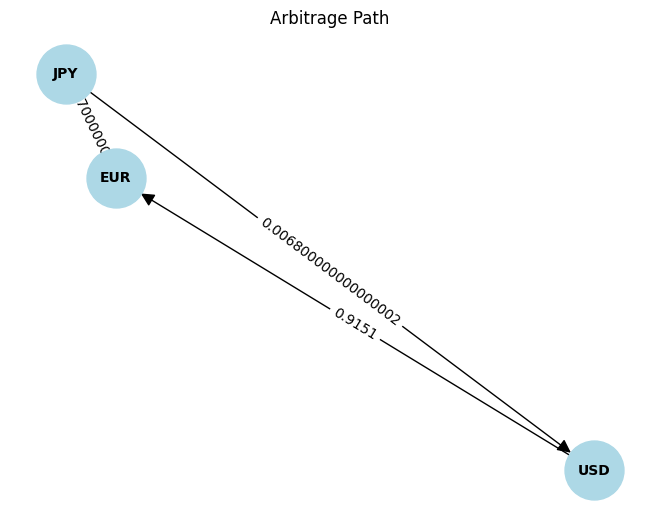

Potential Profit: 0.72%


In [70]:
import networkx as nx


def visualize_arbitrage(log_rates, arbitrage_path):
    G = nx.DiGraph()

    # Add nodes and edges from the arbitrage path
    for i in range(len(arbitrage_path) - 1):
        u = arbitrage_path[i]
        v = arbitrage_path[i + 1]
        rate = np.exp(-log_rates.at[u, v])  # Convert log rate back to the actual rate
        G.add_edge(u, v, weight=rate)
    
    # Visualize the graph
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1800, font_size=10, font_weight='bold', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title("Arbitrage Path")
    plt.show()

    # Calculate and print the profit
    profit = 1
    for i in range(len(arbitrage_path) - 1):
        u = arbitrage_path[i]
        v = arbitrage_path[i + 1]
        profit *= np.exp(-log_rates.at[u, v])
    
    print(f"Potential Profit: {profit - 1:.2%}")

# Assuming `arbitrage_path` is returned from the `bellman_ford` function
if arbitrage_path:
    visualize_arbitrage(log_rates, arbitrage_path)
else:
    print("No arbitrage opportunity found.")
